In [41]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

pd.options.display.float_format = '{:.2f}'.format
np.set_printoptions(precision=2, suppress=True)

# About data

**Context:** Housing values in Boston suburbs (1978). 506 instances, 14 attributes.

**Source:** Harrison & Rubinfeld (1978). Missing Values: None.

## Key Attributes
* **CRIM**: Per capita crime rate.
* **ZN**: Proportion of residential land for large lots (>25k sq.ft).
* **INDUS**: Proportion of non-retail business acres.
* **CHAS**: Charles River dummy (1 if bounds river; 0 otherwise).
* **NOX**: Nitric oxides concentration (pollution).
* **RM**: Avg. number of rooms per dwelling.
* **AGE**: % of units built prior to 1940.
* **DIS**: Distance to employment centers.
* **RAD**: Accessibility to radial highways.
* **TAX**: Property-tax rate.
* **PTRATIO**: Pupil-teacher ratio.
* **B**: Proportion of population of Black descent (statistically transformed).
* **LSTAT**: % lower status of the population.
* **MEDV (Target)**: Median value of owner-occupied homes ($1000s).

In [42]:
df = pd.read_csv('data/housing.csv')
df.head()
df.shape

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.01,18.00,2.31,0,0.54,6.58,65.20,4.09,1,296.00,15.30,396.90,4.98,24.00
1,0.03,0.00,7.07,0,0.47,6.42,78.90,4.97,2,242.00,17.80,396.90,9.14,21.60
2,0.03,0.00,7.07,0,0.47,7.18,61.10,4.97,2,242.00,17.80,392.83,4.03,34.70
3,0.03,0.00,2.18,0,0.46,7.00,45.80,6.06,3,222.00,18.70,394.63,2.94,33.40
4,0.07,0.00,2.18,0,0.46,7.15,54.20,6.06,3,222.00,18.70,396.90,5.33,36.20


(506, 14)

In [43]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    int64  
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    int64  
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
 13  MEDV     506 non-null    float64
dtypes: float64(12), int64(2)
memory usage: 55.5 KB


In [44]:
df.describe().loc[['mean', 'min', 'max']]

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
mean,3.61,11.36,11.14,0.07,0.55,6.28,68.57,3.80,9.55,408.24,18.46,356.67,12.65,22.53
min,0.01,0.00,0.46,0.00,0.39,3.56,2.90,1.13,1.00,187.00,12.60,0.32,1.73,5.00
max,88.98,100.00,27.74,1.00,0.87,8.78,100.00,12.13,24.00,711.00,22.00,396.90,37.97,50.00


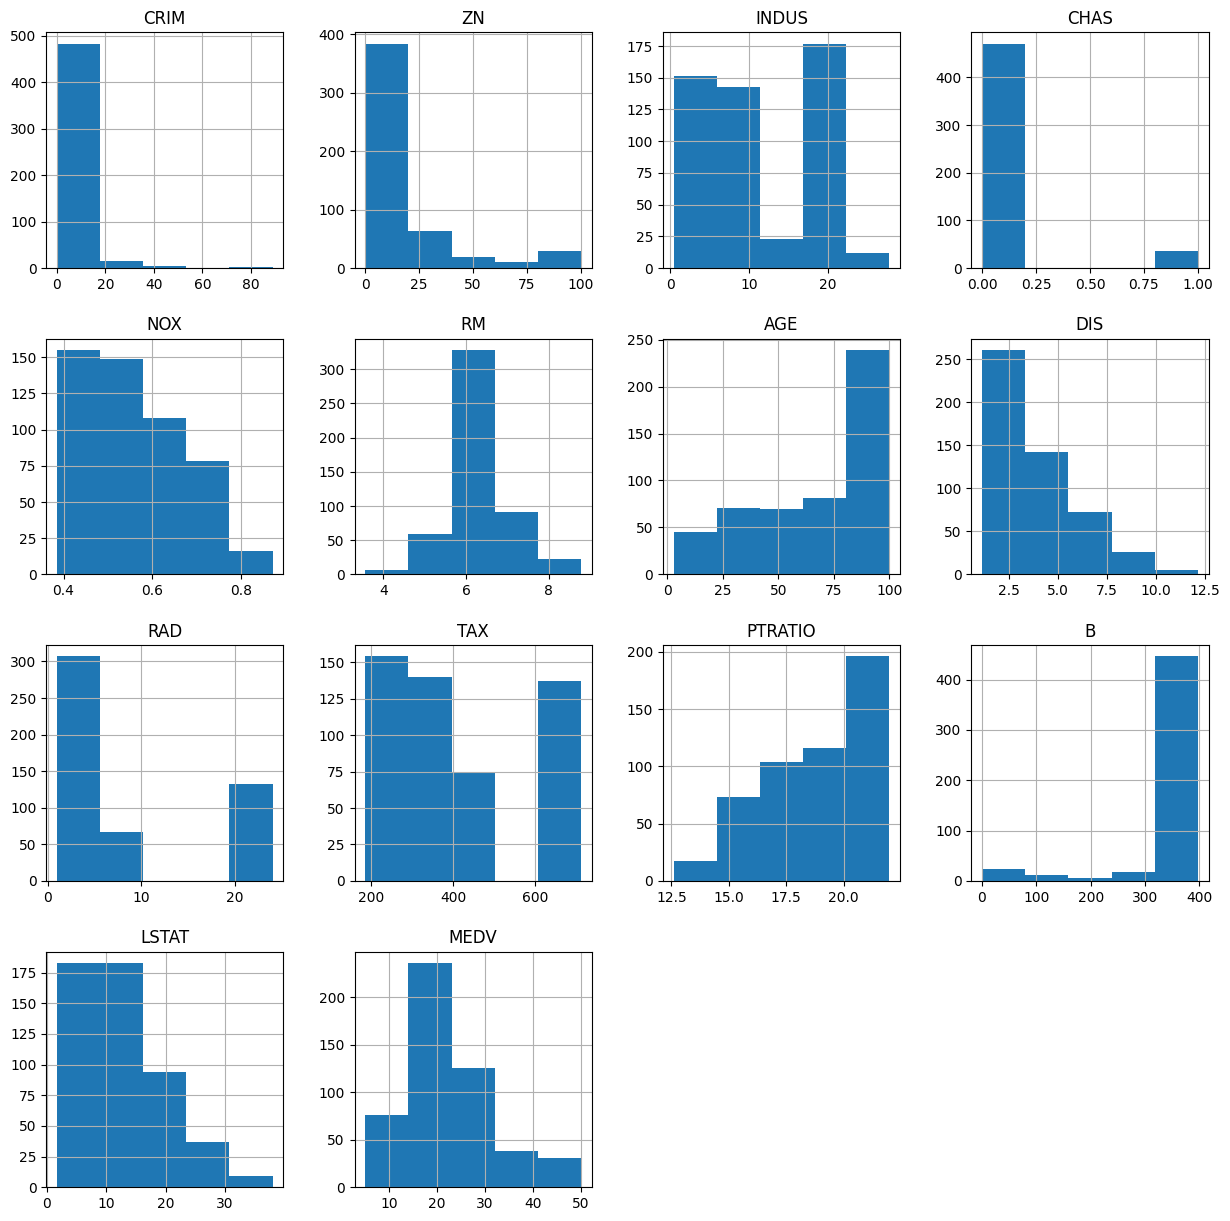

In [45]:
_ = df.hist(bins=5, figsize=(15, 15))

# Train test split

Split whole data in 2 parts
1. Training set: used to train models (80%)
2. Testing set: used to test models (20%)

## Manual split logic

In [46]:
def split_train_test(df, test_ratio=0.2, random_state=42):
  np.random.seed(random_state)
  shuffled = np.random.permutation(len(df))
  test_size = math.ceil(len(df) * test_ratio)

  test_indices = shuffled[:test_size]
  train_indices = shuffled[test_size:]

  test_set = df.iloc[test_indices]
  train_set = df.iloc[train_indices]
  return train_set, test_set


train_set, test_set = split_train_test(df, test_ratio=0.2, random_state=42)

train_set.shape
test_set.shape

(404, 14)

(102, 14)

## Using `train_test_split` from sklearn

In [47]:
from sklearn.model_selection import train_test_split

In [48]:
train_set, test_set = train_test_split(df, test_size=0.2, random_state=42)

train_set.shape
test_set.shape

(404, 14)

(102, 14)

## Stratified sampling

Make sure training and testing sets, both have good diversity

e.g. Suppose 100 students (85 boys, 15 girls)  
Below is a **bad splitting**
- Train set: 80 students (77 boys, 3 girls) <- not enough girls
- Test set: 20 students (8 boys, 12 girls) <- not enough boys

In [49]:
def compare_proportions(df, train, test, col):
  print(f"\n--- Distribution for Column: '{col}' ---")

  # Calculate percentages
  overall = df[col].value_counts(normalize=True).sort_index()
  train_dist = train[col].value_counts(normalize=True).sort_index()
  test_dist = test[col].value_counts(normalize=True).sort_index()

  # Combine into a single dataframe for easy comparison
  comparison = pd.DataFrame({
      "Overall %": overall,
      "Train %": train_dist,
      "Test %": test_dist
  })

  # Fill NaN with 0 (in case a category is missing entirely from a set)
  comparison = comparison.fillna(0)

  # Display as percentage strings
  print(comparison.map(lambda x: f"{x:.1%}"))

Observe the values and their frequency

In [50]:
df['CHAS'].value_counts()
df['RAD'].value_counts()

CHAS
0    471
1     35
Name: count, dtype: int64

RAD
24    132
5     115
4     110
3      38
6      26
2      24
8      24
1      20
7      17
Name: count, dtype: int64

Observe the unequal proportions of different values across train and test sets

In [51]:
compare_proportions(df, train_set, test_set, 'CHAS')
compare_proportions(df, train_set, test_set, 'RAD')


--- Distribution for Column: 'CHAS' ---
     Overall % Train % Test %
CHAS                         
0        93.1%   92.8%  94.1%
1         6.9%    7.2%   5.9%

--- Distribution for Column: 'RAD' ---
    Overall % Train % Test %
RAD                         
1        4.0%    4.2%   2.9%
2        4.7%    5.2%   2.9%
3        7.5%    7.9%   5.9%
4       21.7%   19.8%  29.4%
5       22.7%   23.3%  20.6%
6        5.1%    5.7%   2.9%
7        3.4%    3.7%   2.0%
8        4.7%    5.2%   2.9%
24      26.1%   25.0%  30.4%


Stratified split can technically be applied on a single column

Here we choose the `RAD` column

It is recommended to apply stratified split only on a single column, which you think is going to suffer from the problem of unequal proportions

In [52]:
from sklearn.model_selection import StratifiedShuffleSplit

In [53]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_indices, test_indices in split.split(df, df['RAD']):
  strat_train_set = df.iloc[train_indices]
  strat_test_set = df.iloc[test_indices]

strat_train_set.shape
strat_test_set.shape

(404, 14)

(102, 14)

In [54]:
compare_proportions(df, strat_train_set, strat_test_set, 'RAD')


--- Distribution for Column: 'RAD' ---
    Overall % Train % Test %
RAD                         
1        4.0%    4.0%   3.9%
2        4.7%    4.7%   4.9%
3        7.5%    7.4%   7.8%
4       21.7%   21.8%  21.6%
5       22.7%   22.8%  22.5%
6        5.1%    5.2%   4.9%
7        3.4%    3.5%   2.9%
8        4.7%    4.7%   4.9%
24      26.1%   26.0%  26.5%


# EDA - Exploratory Data Analysis

## Looking into correlations

In [55]:
# EDA should be done ONLY on the train set
# We are not going to look at test set
housing = strat_train_set.copy()

In [56]:
corr = housing.corr().abs()  # Correlation matrix

# Mask the upper triangle (to avoid duplicate pairs like (A, B) and (B, A))
# and remove self-correlation (on diagonals, where corr == 1)
mask1 = np.triu(np.ones(corr.shape), k=1).astype(bool)
mask2 = corr >= 0.6

corr.where(mask1 & mask2).fillna('-')

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
CRIM,-,-,-,-,-,-,-,-,0.67,0.62,-,-,-,-
ZN,-,-,-,-,-,-,-,0.67,-,-,-,-,-,-
INDUS,-,-,-,-,0.75,-,0.64,0.70,-,0.70,-,-,0.63,-
CHAS,-,-,-,-,-,-,-,-,-,-,-,-,-,-
NOX,-,-,-,-,-,-,0.73,0.76,-,0.65,-,-,0.61,-
RM,-,-,-,-,-,-,-,-,-,-,-,-,0.63,0.74
AGE,-,-,-,-,-,-,-,0.74,-,-,-,-,0.61,-
DIS,-,-,-,-,-,-,-,-,-,-,-,-,-,-
RAD,-,-,-,-,-,-,-,-,-,0.90,-,-,-,-
TAX,-,-,-,-,-,-,-,-,-,-,-,-,-,-


In [57]:
relevant_pairs = list(corr.where(mask1 & mask2).stack().dropna().sort_values(ascending=False).index)
len(relevant_pairs)
relevant_pairs[:5]

18

[('RAD', 'TAX'),
 ('NOX', 'DIS'),
 ('INDUS', 'NOX'),
 ('LSTAT', 'MEDV'),
 ('AGE', 'DIS')]

Now we create scatter plot of each pair

We create a single figure that contains many subplots

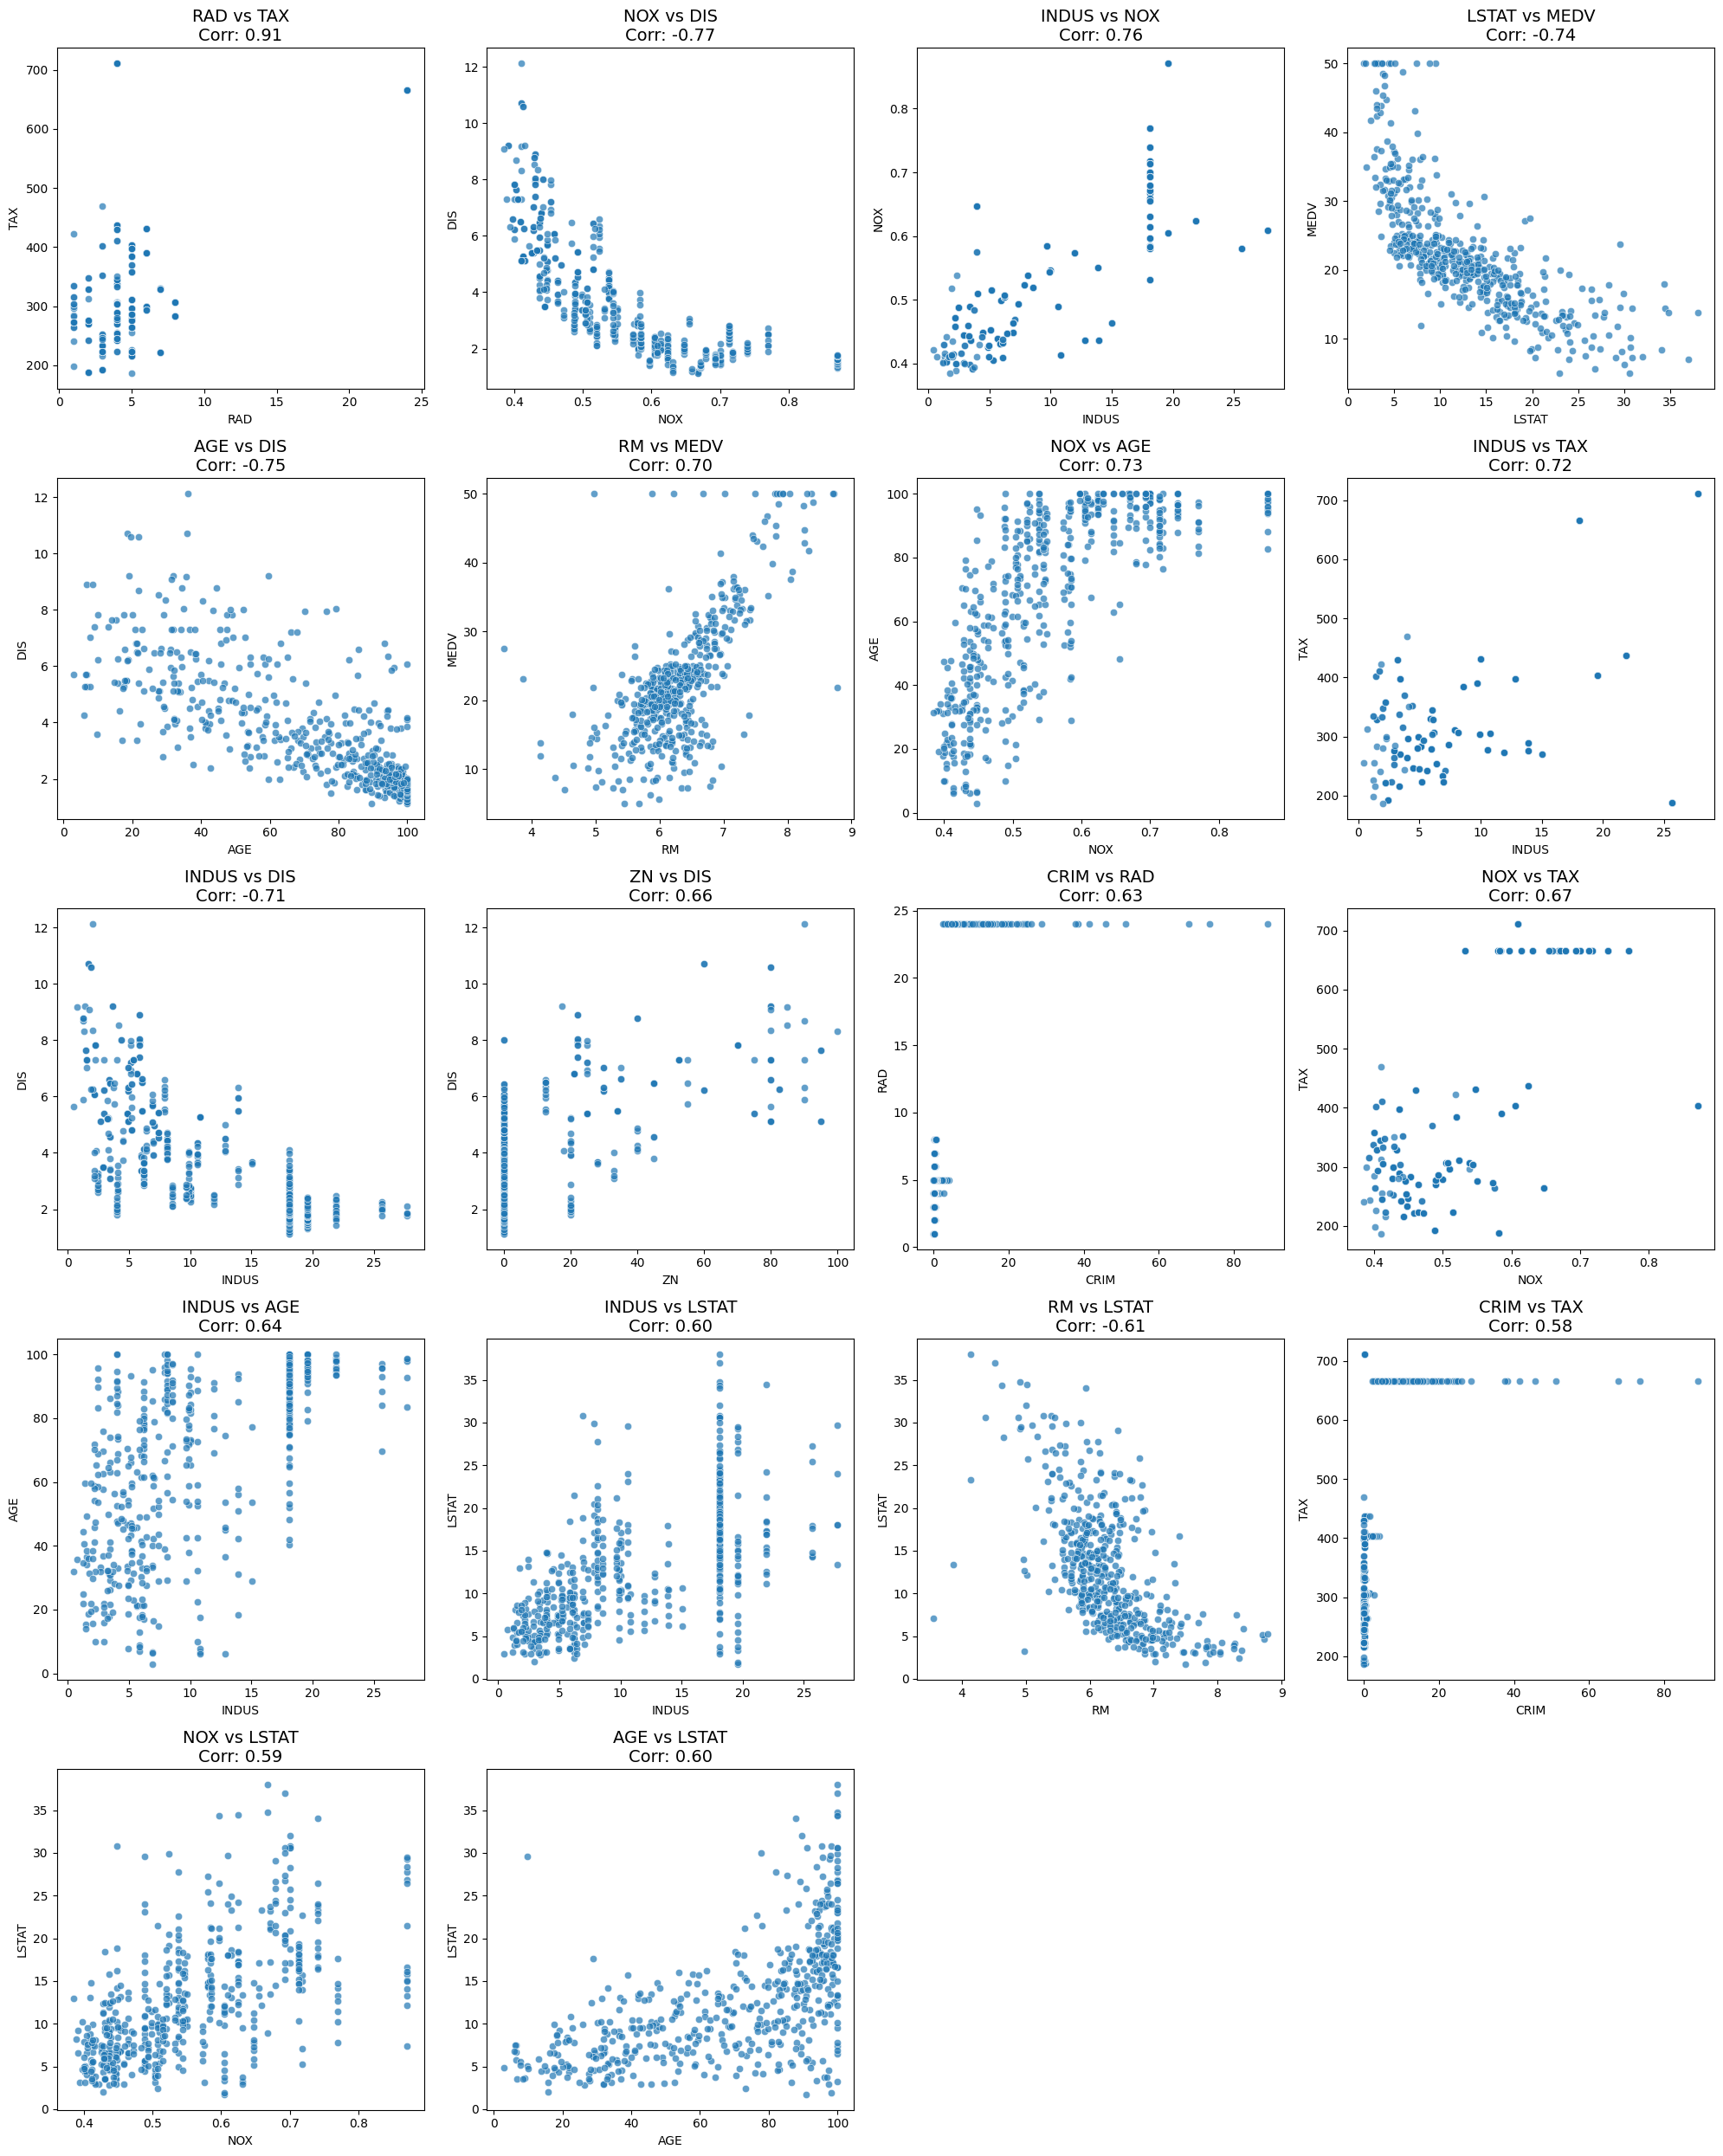

In [58]:
# 1. Calculate grid dimensions
n_plots = len(relevant_pairs)
n_cols = 4
n_rows = math.ceil(n_plots / n_cols)

# 2. Initialize the figure
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5 * n_rows))
axes = axes.flatten()  # Flatten to iterate easily

# 3. Loop through pairs and create plots
for i, (col_x, col_y) in enumerate(relevant_pairs):
  _ = sns.scatterplot(data=df, x=col_x, y=col_y, ax=axes[i], alpha=0.7)

  correlation = df[col_x].corr(df[col_y])
  _ = axes[i].set_title(f"{col_x} vs {col_y}\nCorr: {correlation:.2f}", fontsize=14)

# 4. Remove empty subplots (if any)
for j in range(i + 1, len(axes)):
  _ = fig.delaxes(axes[j])

plt.tight_layout()

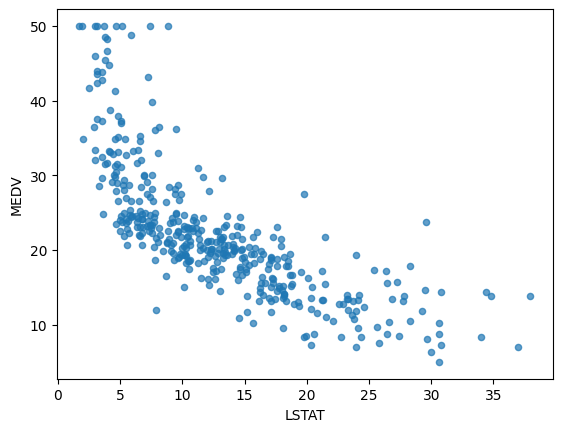

In [59]:
_ = housing.plot(kind='scatter', x='LSTAT', y='MEDV', alpha=0.7)

## Trying attribute combinations

Making new columns from existing columns

Sometimes this unlocks hidden relationships. And using this new column can give better results in regression.

In [60]:
housing['MEDV'].corr(housing['TAX'])
housing['MEDV'].corr(housing['RM'])
housing['MEDV'].corr(housing['TAX']/housing['RM'])  # Not very interesting

np.float64(-0.5094647279086685)

np.float64(0.7394516416728183)

np.float64(-0.5807950477688402)

# Preprocessing

## Split features and label

`X` - The feature matrix (all columns except target)

`y` - The label or target (what we are trying to predict)

In [61]:
X_train = strat_train_set.iloc[:, :-1]
y_train = strat_train_set.iloc[:, -1]

X_test = strat_test_set.iloc[:, :-1]
y_test = strat_test_set.iloc[:, -1]

X_train.shape
y_train.shape

X_test.shape
y_test.shape

(404, 13)

(404,)

(102, 13)

(102,)

## Imputation - filling missing values

⚠️ Imputation and scaling can be done without pipeline. But it's better to use pipeline.

**In this case, luckily our data don't have any missing values**

Imputation is actually not needed here. Doing it anyways for demonstration

⚠️ Rules of imputation (also applies to scaling):
1. Only perform imputation on features, NEVER on target variable
   - If you have missing values in target variable then you have to drop those rows. They are completely useless
2. Fit ONLY on train set, and transform both train and test sets using same imputer/scaler/pipeline

In [62]:
X_train.isnull().sum().sum()  # total nulls across all cols
X_train.isnull().sum()  # nulls per col

np.int64(0)

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
dtype: int64

Deliberately nullifying some values to demonstrate imputation

In [63]:
X_missing = X_train.copy()
X_missing.loc[X_missing.sample(10).index, ['RM']] = pd.NA
X_missing.loc[X_missing.sample(10).index, ['TAX']] = pd.NA
X_missing.isnull().sum()

CRIM        0
ZN          0
INDUS       0
CHAS        0
NOX         0
RM         10
AGE         0
DIS         0
RAD         0
TAX        10
PTRATIO     0
B           0
LSTAT       0
dtype: int64

1. Drop cols having missing values

Note: `.drop()`, `.dropna()` will NOT modify the original data frame unless we do `inplace=True` or reassign in variable

In [64]:
X_missing.drop(columns=['RM', 'TAX']).shape  # 13 cols -> 11 cols

(404, 11)

2. Drop the rows having missing values

In [65]:
X_missing.dropna().shape  # for all rows
X_missing.dropna(subset=['TAX']).shape  # for specific rows

(384, 13)

(394, 13)

3. Fill missing values with mean/median/mode of respective col

Careful while using `.mode()`: Because it's not a single value, but many values

In [66]:
X_missing['TAX'].fillna(X_missing['TAX'].mean()).isnull().sum()
X_missing['RM'].fillna(X_missing['RM'].median()).isnull().sum()

np.int64(0)

np.int64(0)

## Using `SimpleImputer` from sklearn

`.fit()` - algo will learn from data

`.transform()` - algo will apply transformations on data based on learning

⚠️ Always fit ONLY on train set. Then transform the test set using same fitted algo

In [67]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='median')
imputer.fit(X_train)

,"missing_values missing_values: int, float, str, np.nan, None or pandas.NA, default=np.nanThe placeholder for the missing values. All occurrences of`missing_values` will be imputed. For pandas' dataframes withnullable integer dtypes with missing values, `missing_values`can be set to either `np.nan` or `pd.NA`.",nan
,"strategy strategy: str or Callable, default='mean'The imputation strategy.- If ""mean"", then replace missing values using the mean along each column. Can only be used with numeric data.- If ""median"", then replace missing values using the median along each column. Can only be used with numeric data.- If ""most_frequent"", then replace missing using the most frequent value along each column. Can be used with strings or numeric data. If there is more than one such value, only the smallest is returned.- If ""constant"", then replace missing values with fill_value. Can be used with strings or numeric data.- If an instance of Callable, then replace missing values using the scalar statistic returned by running the callable over a dense 1d array containing non-missing values of each column... versionadded:: 0.20 strategy=""constant"" for fixed value imputation... versionadded:: 1.5 strategy=callable for custom value imputation.",'median'
,"fill_value fill_value: str or numerical value, default=NoneWhen strategy == ""constant"", `fill_value` is used to replace alloccurrences of missing_values. For string or object data types,`fill_value` must be a string.If `None`, `fill_value` will be 0 when imputing numericaldata and ""missing_value"" for strings or object data types.",None
,"copy copy: bool, default=TrueIf True, a copy of X will be created. If False, imputation willbe done in-place whenever possible. Note that, in the following cases,a new copy will always be made, even if `copy=False`:- If `X` is not an array of floating values;- If `X` is encoded as a CSR matrix;- If `add_indicator=True`.",True
,"add_indicator add_indicator: bool, default=FalseIf True, a :class:`MissingIndicator` transform will stack onto outputof the imputer's transform. This allows a predictive estimatorto account for missingness despite imputation. If a feature has nomissing values at fit/train time, the feature won't appear onthe missing indicator even if there are missing values attransform/test time.",False
,"keep_empty_features keep_empty_features: bool, default=FalseIf True, features that consist exclusively of missing values when`fit` is called are returned in results when `transform` is called.The imputed value is always `0` except when `strategy=""constant""`in which case `fill_value` will be used instead... versionadded:: 1.2",False


In [68]:
X_train.median().values  # directly seeing median of each col
imputer.statistics_  # median values learnt by imputer

array([  0.23,   0.  ,   9.69,   0.  ,   0.54,   6.21,  77.7 ,   3.12,
         5.  , 332.  ,  19.1 , 390.94,  11.43])

array([  0.23,   0.  ,   9.69,   0.  ,   0.54,   6.21,  77.7 ,   3.12,
         5.  , 332.  ,  19.1 , 390.94,  11.43])

In [69]:
X_imputed = imputer.transform(X_train)
X_imputed  # numpy array (not a dataframe)

array([[  0.08,   0.  ,   4.05, ...,  16.6 , 393.23,   9.64],
       [  0.07,   0.  ,  25.65, ...,  19.1 , 377.67,  14.27],
       [  8.72,   0.  ,  18.1 , ...,  20.2 , 391.98,  17.12],
       ...,
       [  1.61,   0.  ,   8.14, ...,  21.  , 248.31,  20.34],
       [  0.12,  12.5 ,   7.87, ...,  15.2 , 396.9 ,  13.27],
       [  0.15,   0.  ,  25.65, ...,  19.1 , 370.31,  25.41]],
      shape=(404, 13))

In [70]:
X_imputed = pd.DataFrame(X_imputed, columns=X_train.columns)  # numpy array -> dataframe
X_imputed.shape
X_imputed.isnull().sum().sum()  # do we still have null values?

(404, 13)

np.int64(0)

## Feature scaling

Scaling strategies:
1. Min-max scaling - all values will be in [0, 1]
2. Standard scaling - all value such that mean = 0, SD = 1

In [71]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [72]:
scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)
X_train_scaled.describe().loc[['mean', 'std', 'min', 'max']]

,"copy copy: bool, default=TrueIf False, try to avoid a copy and do inplace scaling instead.This is not guaranteed to always work inplace; e.g. if the data isnot a NumPy array or scipy.sparse CSR matrix, a copy may still bereturned.",True
,"with_mean with_mean: bool, default=TrueIf True, center the data before scaling.This does not work (and will raise an exception) when attempted onsparse matrices, because centering them entails building a densematrix which in common use cases is likely to be too large to fit inmemory.",True
,"with_std with_std: bool, default=TrueIf True, scale the data to unit variance (or equivalently,unit standard deviation).",True


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
mean,-0.00,0.00,0.00,-0.00,0.00,-0.00,0.00,0.00,-0.00,-0.00,0.00,-0.00,0.00
std,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
min,-0.45,-0.49,-1.55,-0.27,-1.46,-3.80,-2.31,-1.26,-0.98,-1.32,-2.74,-3.77,-1.52
max,9.34,3.83,2.38,3.74,2.70,3.49,1.12,4.00,1.67,1.79,1.63,0.45,3.50


In [73]:
scaler = MinMaxScaler()
scaler.fit(X_train)

X_train_scaled = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)
X_train_scaled.describe().loc[['min', 'max']]

,"feature_range feature_range: tuple (min, max), default=(0, 1)Desired range of transformed data.","(0, ...)"
,"copy copy: bool, default=TrueSet to False to perform inplace row normalization and avoid acopy (if the input is already a numpy array).",True
,"clip clip: bool, default=FalseSet to True to clip transformed values of held-out data toprovided `feature_range`.Since this parameter will clip values, `inverse_transform` may notbe able to restore the original data... note:: Setting `clip=True` does not prevent feature drift (a distribution shift between training and test data). The transformed values are clipped to the `feature_range`, which helps avoid unintended behavior in models sensitive to out-of-range inputs (e.g. linear models). Use with care, as clipping can distort the distribution of test data... versionadded:: 0.24",False


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
max,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


## Preprocessing pipeline

In [74]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('SimpleImputer', SimpleImputer(strategy='median')),
    ('StandardScaler', StandardScaler()),
])

# Fit ONLY on train set
pipeline.fit(X_train)

# Transform both train and test sets using same pipeline
X_train_tr = pd.DataFrame(pipeline.transform(X_train), columns=X_train.columns)
X_test_tr = pd.DataFrame(pipeline.transform(X_test), columns=X_test.columns)

X_train_tr.shape
X_test_tr.shape

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('SimpleImputer', ...), ('StandardScaler', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"missing_values missing_values: int, float, str, np.nan, None or pandas.NA, default=np.nanThe placeholder for the missing values. All occurrences of`missing_values` will be imputed. For pandas' dataframes withnullable integer dtypes with missing values, `missing_values`can be set to either `np.nan` or `pd.NA`.",nan
,"strategy strategy: str or Callable, default='mean'The imputation strategy.- If ""mean"", then replace missing values using the mean along each column. Can only be used with numeric data.- If ""median"", then replace missing values using the median along each column. Can only be used with numeric data.- If ""most_frequent"", then replace missing using the most frequent value along each column. Can be used with strings or numeric data. If there is more than one such value, only the smallest is returned.- If ""constant"", then replace missing values with fill_value. Can be used with strings or numeric data.- If an instance of Callable, then replace missing values using the scalar statistic returned by running the callable over a dense 1d array containing non-missing values of each column... versionadded:: 0.20 strategy=""constant"" for fixed value imputation... versionadded:: 1.5 strategy=callable for custom value imputation.",'median'
,"fill_value fill_value: str or numerical value, default=NoneWhen strategy == ""constant"", `fill_value` is used to replace alloccurrences of missing_values. For string or object data types,`fill_value` must be a string.If `None`, `fill_value` will be 0 when imputing numericaldata and ""missing_value"" for strings or object data types.",None
,"copy copy: bool, default=TrueIf True, a copy of X will be created. If False, imputation willbe done in-place whenever possible. Note that, in the following cases,a new copy will always be made, even if `copy=False`:- If `X` is not an array of floating values;- If `X` is encoded as a CSR matrix;- If `add_indicator=True`.",True
,"add_indicator add_indicator: bool, default=FalseIf True, a :class:`MissingIndicator` transform will stack onto outputof the imputer's transform. This allows a predictive estimatorto account for missingness despite impu

(404, 13)

(102, 13)

# Model selection

In [75]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import cross_val_score

## Cross validation scores

⚠️ The entire train set is already scaled. This is not good for running cross validation.

- The better way is to include model as last step of pipeline, then do `cross_val_score(pipeline, ...)`.
  
- But we're not doing it here for simplicity.

In [76]:
def cross_validation(model):
  scores = cross_val_score(model, X_train_tr, y_train, scoring='neg_mean_squared_error', cv=10)
  rmse_scores = np.sqrt(-scores)

  print("Cross validation results:")
  print(f'  Mean RMSE = {rmse_scores.mean():.2f}')
  print(f'  Std RMSE = {rmse_scores.std():.2f}')

In [77]:
model = LinearRegression()
model.fit(X_train_tr, y_train)
y_pred = model.predict(X_test_tr)

cross_validation(model)  # cross validation on train set (already seen data)
root_mean_squared_error(y_test, y_pred)  # final evaluation (on unseen data)

# ⚠️👆 For demo purposes, we are directly using the test set for evaluation here.
# But the standard way is to use the test set ONLY IN THE LAST when you have selected a model based on cross validation.

,"fit_intercept fit_intercept: bool, default=TrueWhether to calculate the intercept for this model. If setto False, no intercept will be used in calculations(i.e. data is expected to be centered).",True
,"copy_X copy_X: bool, default=TrueIf True, X will be copied; else, it may be overwritten.",True
,"tol tol: float, default=1e-6The precision of the solution (`coef_`) is determined by `tol` whichspecifies a different convergence criterion for the `lsqr` solver.`tol` is set as `atol` and `btol` of :func:`scipy.sparse.linalg.lsqr` whenfitting on sparse training data. This parameter has no effect when fittingon dense data... versionadded:: 1.7",1e-06
,"n_jobs n_jobs: int, default=NoneThe number of jobs to use for the computation. This will only providespeedup in case of sufficiently large problems, that is if firstly`n_targets > 1` and secondly `X` is sparse or if `positive` is setto `True`. ``None`` means 1 unless in a:obj:`joblib.parallel_backend` context. ``-1`` means using allprocessors. See :term:`Glossary ` for more details.",None
,"positive positive: bool, default=FalseWhen set to ``True``, forces the coefficients to be positive. Thisoption is only supported for dense arrays.For a comparison between a linear regression model with positive constraintson the regression coefficients and a linear regression without such constraints,see :ref:`sphx_glr_auto_examples_linear_model_plot_nnls.py`... versionadded:: 0.24",False


Cross validation results:
  Mean RMSE = 4.43
  Std RMSE = 0.57


6.549992419890326

In [78]:
model = DecisionTreeRegressor(random_state=42)
model.fit(X_train_tr, y_train)
y_pred = model.predict(X_test_tr)

cross_validation(model)
root_mean_squared_error(y_test, y_pred)

,"criterion criterion: {""squared_error"", ""friedman_mse"", ""absolute_error"", ""poisson""}, default=""squared_error""The function to measure the quality of a split. Supported criteriaare ""squared_error"" for the mean squared error, which is equal tovariance reduction as feature selection criterion and minimizes the L2loss using the mean of each terminal node, ""friedman_mse"", which usesmean squared error with Friedman's improvement score for potentialsplits, ""absolute_error"" for the mean absolute error, which minimizesthe L1 loss using the median of each terminal node, and ""poisson"" whichuses reduction in the half mean Poisson deviance to find splits... versionadded:: 0.18 Mean Absolute Error (MAE) criterion... versionadded:: 0.24 Poisson deviance criterion.",'squared_error'
,"splitter splitter: {""best"", ""random""}, default=""best""The strategy used to choose the split at each node. Supportedstrategies are ""best"" to choose the best split and ""random"" to choosethe best random split.",'best'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.For an example of how ``max_depth`` influences the model, see:ref:`sphx_glr_auto_examples_tree_plot_tree_regression.py`.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: int, float or {""sqrt"", ""log2""}, default=NoneThe number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",None
,"random_state random_state: int, RandomState instance or None, default=NoneControls the randomness of the estimator. The features are alwaysrandomly permuted at each split, even if ``splitter`` is set to``""best""``. When ``max_features < n_features``, the algorithm willselect ``max_features`` at random at each split before finding the bestsplit among them. But the best found split may vary across differentruns, even if ``max_features=n_features``. That is the case, if theimprovement of the criterion is identical for several splits and onesplit has to be selected at random. To obtain a deterministic behaviourduring fitting, ``random_state`` has to be fixed to an integer.See :term:`Glossary ` for details.",42
,"max_l

Cross validation results:
  Mean RMSE = 3.94
  Std RMSE = 0.71


5.975300468283961

In [79]:
model = RandomForestRegressor(random_state=42)
model.fit(X_train_tr, y_train)
y_pred = model.predict(X_test_tr)

cross_validation(model)
root_mean_squared_error(y_test, y_pred)

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",100
,"criterion criterion: {""squared_error"", ""absolute_error"", ""friedman_mse"", ""poisson""}, default=""squared_error""The function to measure the quality of a split. Supported criteriaare ""squared_error"" for the mean squared error, which is equal tovariance reduction as feature selection criterion and minimizes the L2loss using the mean of each terminal node, ""friedman_mse"", which usesmean squared error with Friedman's improvement score for potentialsplits, ""absolute_error"" for the mean absolute error, which minimizesthe L1 loss using the median of each terminal node, and ""poisson"" whichuses reduction in Poisson deviance to find splits.Training using ""absolute_error"" is significantly slowerthan when using ""squared_error""... versionadded:: 0.18 Mean Absolute Error (MAE) criterion... versionadded:: 1.0 Poisson criterion.",'squared_error'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=1.0The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None or 1.0, then `max_features=n_features`... note:: The default of 1.0 is equivalent to bagged trees and more randomness can be achieved by setting smaller values, e.g. 0.3... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to 1.0.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",1.0
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsample

Cross validation results:
  Mean RMSE = 3.21
  Std RMSE = 0.87


5.004365521673032

In [80]:
model = SVR()
model.fit(X_train_tr, y_train)
y_pred = model.predict(X_test_tr)

cross_validation(model)
root_mean_squared_error(y_test, y_pred)

,"kernel kernel: {'linear', 'poly', 'rbf', 'sigmoid', 'precomputed'} or callable, default='rbf'Specifies the kernel type to be used in the algorithm.If none is given, 'rbf' will be used. If a callable is given it isused to precompute the kernel matrix.For an intuitive visualization of different kernel typessee :ref:`sphx_glr_auto_examples_svm_plot_svm_regression.py`",'rbf'
,"degree degree: int, default=3Degree of the polynomial kernel function ('poly').Must be non-negative. Ignored by all other kernels.",3
,"gamma gamma: {'scale', 'auto'} or float, default='scale'Kernel coefficient for 'rbf', 'poly' and 'sigmoid'.- if ``gamma='scale'`` (default) is passed then it uses 1 / (n_features * X.var()) as value of gamma,- if 'auto', uses 1 / n_features- if float, must be non-negative... versionchanged:: 0.22 The default value of ``gamma`` changed from 'auto' to 'scale'.",'scale'
,"coef0 coef0: float, default=0.0Independent term in kernel function.It is only significant in 'poly' and 'sigmoid'.",0.0
,"tol tol: float, default=1e-3Tolerance for stopping criterion.",0.001
,"C C: float, default=1.0Regularization parameter. The strength of the regularization isinversely proportional to C. Must be strictly positive.The penalty is a squared l2. For an intuitive visualization of theeffects of scaling the regularization parameter C, see:ref:`sphx_glr_auto_examples_svm_plot_svm_scale_c.py`.",1.0
,"epsilon epsilon: float, default=0.1Epsilon in the epsilon-SVR model. It specifies the epsilon-tubewithin which no penalty is associated in the training loss functionwith points predicted within a distance epsilon from the actualvalue. Must be non-negative.",0.1
,"shrinking shrinking: bool, default=TrueWhether to use the shrinking heuristic.See the :ref:`User Guide `.",True
,"cache_size cache_size: float, default=200Specify the size of the kernel cache (in MB).",200
,"verbose verbose: bool, default=FalseEnable verbose output. Note that this setting takes advantage of aper-process runtime setting in libsvm that, if enabled, may not workproperly in a multithreaded context.",False
,"max_iter max_iter: int, default=-1Hard limit on iterations within solver, or -1 for no limit.",-1


Cross validation results:
  Mean RMSE = 4.91
  Std RMSE = 0.56


7.324258742310092